In [47]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Input, Dense, Activation, BatchNormalization, Permute, Flatten,Lambda, Masking
from tensorflow.keras.layers import add, concatenate
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional, MaxPool2D, Reshape
from tensorflow.keras import optimizers
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import glob, cv2
from tensorflow.keras.optimizers import Adam
#import editdistance
from sklearn.model_selection import train_test_split
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [31]:
import glob
from skimage.filters import sobel
from skimage.util import invert
from skimage.color import rgb2gray
imgs=[]
ims=[]
img_list = sorted(glob.glob('/content/drive/MyDrive/Colab_Notebooks/Nega/line-images/*.PNG'))
for i, img_path in enumerate(img_list):
  ims=cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
  th2 = cv2.adaptiveThreshold(ims,170,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,25,15)
  imgs.append(th2)

In [32]:
imgs[1999].shape

(37, 654)

In [34]:
def preprocess(image):
    #(h, w) = imge.shape
    #final_img = np.ones([32, 256])*255 # black white image
    #if h > 32 & w > 256:                       # crop
    #    img = imge[:32, :256]
     #
      #  final_img[:h, :w] = img
    final_image=cv2.resize(image, (48, 256))
    return cv2.rotate(final_image, cv2.ROTATE_90_CLOCKWISE)

In [35]:
dim=(256, 48)
def im_resize(input_image):
    #f=cv2.transpose(input_image)
    im_resize=cv2.resize(input_image, dim)
    return im_resize

In [36]:
train = []
valid = []

for i in range(len(imgs)):
    image = im_resize(imgs[i])
    image = image/255.
    if i%10 == 0:
        valid.append(image)
    else:
        train.append(image)


(48, 256)

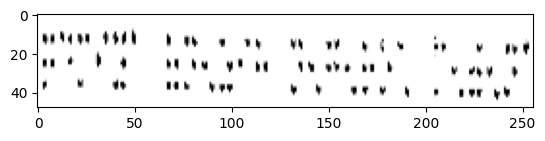

In [37]:
plt.imshow(valid[9], cmap='gray')
valid[0].shape

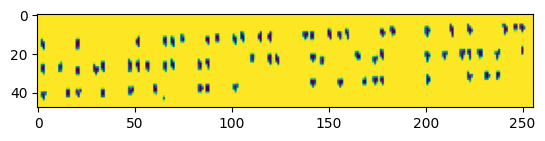

In [38]:
plt.imshow(train[1799])

In [39]:
alphabets = ' ሀሁሂሃሄህሆለሉሊላሌልሎሐሑሒሓሔሕሖመሙሚማሜምሞሰሱሲሳሴስሶረሩሪራሬርሮሠሡሢሣሤሥሦሸሹሺሻሼሽሾቀቁቂቃቄቅቆበቡቢባቤብቦተቱቲታቴትቶቸቹቺቻቼችቾኀኁኂኃኄኅኆነኑኒናኔንኖኘኙኚኛኜኝኞአኡኢኣኤእኦከኩኪካኬክኮኸኹኺኻኼኽኾወዉዊዋዌውዎዐዑዒዓዔዕዖዘዙዚዛዜዝዞዠዡዢዣዤዥዦየዩዪያዬይዮደዱዲዳዴድዶጀጁጂጃጄጅጆገጉጊጋጌግጎጠጡጢጣጤጥጦጨጩጪጫጬጭጮጰጱጲጳጴጵጶጸጹጺጻጼጽጾፀፁፂፃፄፅፆፈፉፊፋፌፍፎፐፑፒፓፔፕፖቨቩቪቫቬቭቮ0123456789፥፣()-ሏሟሷሯሿቧቆቇቈቋቊቷቿኗኟዟዧኈኊኊኋኌዷጇጧጯጿፏኰኵኲኳኴኧቯጐጕጒጓጔ።'
num_of_characters = len(alphabets) + 1 # +1 for ctc pseudo blank(epsilon)
num_of_timestamps = 24 # max length of predicted labels


def label_to_num(label):
    label_num = []
    for ch in label:
        label_num.append(alphabets.find(ch))
        #find() method returns the lowest index of the substring if it is found in given string otherwise -1

    return np.array(label_num)

def num_to_label(num):
    ret = ""
    for ch in num:
        if ch == -1:  # CTC Blank
            break
        else:
            ret+=alphabets[ch]
    return ret

In [43]:
max_label_len=0

train_y = []
train_input_length = []
train_label_length = []
train_original_text = []

valid_y = []
valid_input_length = []
valid_label_length = []
valid_original_text = []
with open('/content/drive/MyDrive/Colab_Notebooks/Nega/label.txt', encoding="utf8") as f:
    contents = f.readlines()[0:]

lines = [line.strip() for line in contents]
for i in range(len(lines)):
    try:
        if len(lines[i]) > max_label_len:
            max_label_len = len(lines[i])
        if i%10 == 0:
            valid_original_text.append(lines[i])
            valid_label_length.append(len(lines[i]))
            valid_input_length.append(61)
            valid_y.append(label_to_num(lines[i]))
        else:
            train_original_text.append(lines[i])
            train_label_length.append(len(lines[i]))
            train_input_length.append(61)
            train_y.append(label_to_num(lines[i]))
    except Exception as e:
        print("Label Encoding Error Occurred", e)

In [44]:
name = 'አበበ በሶ በላ።'
print(name, '\n',label_to_num(name))
print(valid_y[3])

አበበ በሶ በላ። 
 [106  64  64   0  64  35   0  64  11 294]
[287 132 294   0 155  24  22  36  71 132   0 106  46   0   8  27 181  69
  92]


In [48]:
train_x = np.asarray(train).reshape(-1, 48, 256, 1)#array will get reshaped in such a way that the resulting array has only 1 column
valid_x = np.asarray(valid).reshape(-1, 48, 256, 1) #(16384,1)

train_pad_txt = pad_sequences(train_y, maxlen=max_label_len, padding='post', value = len(alphabets))
valid_pad_txt = pad_sequences(valid_y, maxlen=max_label_len, padding='post', value = len(alphabets))

train_input_length=np.asarray([train_input_length[i] for i in range (len(train_y))])
valid_input_length=np.asarray([valid_input_length[i] for i in range (len(valid_y))])

train_label_length=np.asarray([train_label_length[i] for i in range (len(train_y))])
valid_label_length=np.asarray([valid_label_length[i] for i in range (len(valid_y))])

In [49]:
train_x.shape

(1800, 48, 256, 1)

## Building our model


In [50]:
input_data = Input(shape=(48, 256, 1), name='input')

con1 = Conv2D(64, (3, 3), activation = 'relu', padding='same', name='conv1', kernel_initializer='he_normal')(input_data)
pool1 = MaxPooling2D(pool_size=(2, 2), name='max1')(con1)

con2 = Conv2D(128, (3, 3), activation = 'relu', padding='same', name='conv2', kernel_initializer='he_normal')(pool1)
pool2 = MaxPooling2D(pool_size=(2, 2), name='max2')(con2)

con3 = Conv2D(256, (3, 3), activation = 'relu', padding='same', name='conv3', kernel_initializer='he_normal')(pool2)

con4 = Conv2D(256, (3, 3), activation = 'relu', padding='same', name='conv4', kernel_initializer='he_normal')(con3)
pool3 = MaxPooling2D(pool_size=(2, 1), name='max3')(con4)

con5 = Conv2D(512, (3, 3), activation = 'relu', padding='same', name='conv5', kernel_initializer='he_normal')(pool3)
norm1 = BatchNormalization()(con5)

con6 = Conv2D(512, (3, 3), activation = 'relu', padding='same', name='conv6', kernel_initializer='he_normal')(norm1)
norm2 = BatchNormalization()(con6)
pool4 = MaxPooling2D(pool_size=(3, 1), name='max5')(norm2)

#inner = Conv2D(512, (3, 3), activation = 'relu', padding='same', name='conv7', kernel_initializer='he_normal')(inner)

con7 = Conv2D(512, (2,2), activation = 'relu')(pool4)


# CNN to RNN
squeezed = Lambda(lambda x: K.squeeze(x, 1))(con7)

## RNN
inner1 = Bidirectional(LSTM(128, return_sequences=True, dropout = 0.2), name = 'lstm1')(squeezed)
inner2 = Bidirectional(LSTM(128, return_sequences=True, dropout = 0.2), name = 'lstm2')(inner1)

## OUTPUT
dense = Dense(num_of_characters, kernel_initializer='he_normal',name='dense2')(inner2)
outputs = Activation('softmax', name='softmax')(dense)

model = Model(inputs=input_data, outputs=outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 48, 256, 1)]      0         
                                                                 
 conv1 (Conv2D)              (None, 48, 256, 64)       640       
                                                                 
 max1 (MaxPooling2D)         (None, 24, 128, 64)       0         
                                                                 
 conv2 (Conv2D)              (None, 24, 128, 128)      73856     
                                                                 
 max2 (MaxPooling2D)         (None, 12, 64, 128)       0         
                                                                 
 conv3 (Conv2D)              (None, 12, 64, 256)       295168    
                                                                 
 conv4 (Conv2D)              (None, 12, 64, 256)       590080

In [51]:
# the ctc loss function
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    y_pred = y_pred[:, 2:, :]# the 2 is critical here since the first couple outputs of the RNN tend to be garbage

    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

In [52]:
labels = Input(name='gtruth_labels', shape=[max_label_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

ctc_loss = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([outputs, labels, input_length, label_length])
model_final = Model(inputs=[input_data, labels, input_length, label_length], outputs=ctc_loss)

In [53]:
model_final.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer='Adam', metrics=['accuracy'])
# the loss calculation occurs elsewhere, so we use a dummy lambda function for the loss

file_path_best = "C_LSTM_best.hdf5"
checkpoint = ModelCheckpoint(filepath=file_path_best, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
callbacks_list = [checkpoint]

## Train our model

In [55]:
history = model_final.fit(x=[train_x, train_pad_txt, train_input_length, train_label_length], y=np.zeros(len(train_y)), batch_size=300, epochs=30,
                          validation_data=([valid_x, valid_pad_txt, valid_input_length, valid_label_length], [np.zeros(len(valid_y))]),
                          callbacks = callbacks_list, verbose=1 )

Epoch 1/30
6/6 [==============================] - ETA: 0s - loss: 56.1997 - accuracy: 0.0000e+00
Epoch 1: val_loss did not improve from 79.99745
6/6 [==============================] - 6s 1s/step - loss: 56.1997 - accuracy: 0.0000e+00 - val_loss: 98.1138 - val_accuracy: 0.0000e+00
Epoch 2/30
6/6 [==============================] - ETA: 0s - loss: 52.3269 - accuracy: 0.0000e+00
Epoch 2: val_loss improved from 79.99745 to 77.55224, saving model to C_LSTM_best.hdf5
6/6 [==============================] - 6s 956ms/step - loss: 52.3269 - accuracy: 0.0000e+00 - val_loss: 77.5522 - val_accuracy: 0.0000e+00
Epoch 3/30
6/6 [==============================] - ETA: 0s - loss: 48.0633 - accuracy: 0.0000e+00
Epoch 3: val_loss improved from 77.55224 to 61.44187, saving model to C_LSTM_best.hdf5
6/6 [==============================] - 7s 1s/step - loss: 48.0633 - accuracy: 0.0000e+00 - val_loss: 61.4419 - val_accuracy: 0.0000e+00
Epoch 4/30
6/6 [==============================] - ETA: 0s - loss: 43.7279 - 

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
#plot accuracy and loss
def plotgraph(epochs, acc, val_acc):
    # Plot training & validation accuracy values
    plt.plot(epochs, acc, 'b')
    plt.plot(epochs, val_acc, 'r')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1,len(loss)+1)

In [ ]:
plotgraph(epochs, loss, val_loss)

In [ ]:
model.load_weights('C_LSTM_best.hdf5')

## Check model performance on validation set

In [ ]:
preds = model.predict(valid_x)
decoded = K.get_value(K.ctc_decode(preds, input_length=np.ones(preds.shape[0])*preds.shape[1],
                                   greedy=True)[0][0])

prediction = []
for i in range(50):
    prediction.append(num_to_label(decoded[i]))

In [ ]:
y_true = valid_y
correct_char = 0
total_char = 0
correct = 0

for i in range(50):
    pr = prediction[i]
    tr = valid_y[i]
    total_char += len(tr)

    for j in range(min(len(tr), len(pr))):
        if tr[j] == pr[j]:
            correct_char += 1

    if pr == tr :
        correct += 1

print('Correct characters predicted : %.2f%%' %(correct_char*100/total_char))

## Some predictions on test set

In [ ]:
plt.figure(figsize=(15, 10))
for i in range(16):
    ax = plt.subplot(4, 4, i+1)
    image = valid[i]
    plt.imshow(image)
    image = preprocess(image)
    image = image/255.
    pred = model.predict(image.reshape(-1, 32, 256, 1))
    decoded = K.get_value(K.ctc_decode(pred, input_length=np.ones(pred.shape[0])*pred.shape[1],
                                       greedy=True)[0][0])
    plt.title(num_to_label(decoded[0]), fontsize=12)
    plt.axis('off')

plt.subplots_adjust(wspace=0.1, hspace=-0.9)

In [ ]:
plt.figure(figsize=(1, 1))
for i in range(1):
    ax = plt.subplot(1, 1, i+1)
    img_dir = "/content/drive/MyDrive/Colab_Notebooks/line-images/0001.PNG"
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap='gray')

    image = preprocess(image)
    image = image/255
    pred = model.predict(image.reshape(1, 32, 256, 1))
    decoded = K.get_value(K.ctc_decode(pred, input_length=np.ones(pred.shape[0])*pred.shape[1],
                                       greedy=True)[0][0])
    plt.title(num_to_label(decoded[0]), fontsize=12)
    plt.axis('off')

1/1 [==============================] - 0s 25ms/step


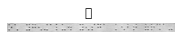

In [ ]:

plt.figure(figsize=(3, 1))
for i in range(1):
    ax = plt.subplot(1, 1, i+1)
    img_dir = "/content/drive/MyDrive/Colab_Notebooks/line-images/0001.PNG"
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap='gray')

    image = preprocess(image)
    image = image/255
    pred = model.predict(image.reshape(1, 32, 256, 1))
    decoded = K.get_value(K.ctc_decode(pred, input_length=np.ones(pred.shape[0])*pred.shape[1],
                                       greedy=True)[0][0])
    plt.title(num_to_label(decoded[0]), fontsize=12)
    plt.axis('off')